# Planetary Data Analysis Notebook

For the first part of this script, I will solely focus on the kNN supervised learning technique applied to the data pertaining to exoplanets from NASA.

In [1]:
# Import necessary libraries
from random import seed
from random import randrange
from numpy.random import rand
from numpy.random import randint
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statistics
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from scipy import stats
from math import sqrt
#import plotly.express as px

In [2]:
# Assign path of data to a variable.
# Initiate first data frame with raw data.
seed(11)
path = 'https://raw.githubusercontent.com/jbravo87/blog-projects/main/data/PS_2022.05.10_21.48.38.csv'
raw_data = pd.read_csv(path, skiprows = 12)

Need to remove the first twelve rows. These rows contain copious notes/remarks. Want to see the head and tail of the data as well as the column names.

In [3]:
raw_data

,pl_name,hostname,pl_orbper,pl_bmassj,pl_orbeccen,pl_eqt
0,11 Com b,11 Com,326.03000,19.40,0.231,NaN
1,11 Com b,11 Com,NaN,17.10,NaN,NaN
2,11 UMi b,11 UMi,NaN,10.80,NaN,NaN
3,11 UMi b,11 UMi,516.21997,14.74,0.080,NaN
4,11 UMi b,11 UMi,516.22000,10.50,0.080,NaN
...,...,...,...,...,...,...
32511,ups And d,ups And,1282.41000,4.10,0.294,NaN
32512,ups And d,ups And,1281.50700,10.25,0.316,NaN
32513,ups Leo b,ups Leo,385.20000,0.51,0.320,NaN
32514,xi Aql b,xi Aql,NaN,2.02,NaN,NaN


In [4]:
raw_data.columns

Index(['pl_name', 'hostname', 'pl_orbper', 'pl_bmassj', 'pl_orbeccen',
       'pl_eqt'],
      dtype='object')

Now want to create first data frame with columns of interest. In this first case/scenario want to study planet eccentricity (dependent/response variable) as a function of orbital period of planet (independent/predictor variable).

### Scenario 1 - eccentricity as function of orbital period

In [5]:
df1 = raw_data.loc[:, ['pl_name','pl_orbper','pl_orbeccen']]
#df1.reset_index(drop=True, inplace=True) # <- Perhaps use this logic in a couple of lines.
df1

,pl_name,pl_orbper,pl_orbeccen
0,11 Com b,326.03000,0.231
1,11 Com b,NaN,NaN
2,11 UMi b,NaN,NaN
3,11 UMi b,516.21997,0.080
4,11 UMi b,516.22000,0.080
...,...,...,...
32511,ups And d,1282.41000,0.294
32512,ups And d,1281.50700,0.316
32513,ups Leo b,385.20000,0.320
32514,xi Aql b,NaN,NaN


Will rename the columns of interest for ease, i.e. make analysis clearer, and remove unnecessary rows by removing all the NA values from the original data frame.

In [6]:
df1 = df1.rename(columns={'pl_name':'planetname', 'pl_orbper':'orbitperiod', 'pl_orbeccen':'eccentricity'})
df1 = df1.dropna()
df1

,planetname,orbitperiod,eccentricity
0,11 Com b,326.03000,0.2310
3,11 UMi b,516.21997,0.0800
4,11 UMi b,516.22000,0.0800
6,14 And b,185.84000,0.0000
7,14 Her b,1766.41000,0.3674
...,...,...,...
32510,ups And d,1274.60000,0.2420
32511,ups And d,1282.41000,0.2940
32512,ups And d,1281.50700,0.3160
32513,ups Leo b,385.20000,0.3200


The following logic is to determine the data types of the column entries in the latest data frame. Again, this is the data type (dtype) for individual entries within the data frame.

In [7]:
print(type(df1.iloc[0][1]))
print(type(df1.iloc[0][2]))

<class 'numpy.float64'>
<class 'numpy.float64'>


In [8]:
type(df1)

pandas.core.frame.DataFrame

In [9]:
print("The data type of the eccentricity column is:", df1.dtypes['eccentricity'])

The data type of the eccentricity column is: float64


Notice df1 is indeed a data frame, and the entries within are numpy float number type.

Want to limit each scenario to two dataframes. Once cleaned, need another to take arithmetic mean of multiple entries. For example, Dataframe 2 will take the averages of multiple planet entries. Following lines will take arithmetic mean of the two columns of interest and concate the two columns into the third dataframe.

First will create intermediate variables to store the resulting averages.

In [10]:
#x4 = df2.groupby('planetname')['eccentricity'].mean()
eccen = df1.groupby('planetname')['eccentricity'].mean()
#x5 = df2.groupby('planetname')['orbitperiod'].mean()
orbper = df1.groupby('planetname')['orbitperiod'].mean()

In [11]:
print(eccen)
print(orbper)

planetname
11 Com b      0.231000
11 UMi b      0.080000
14 And b      0.000000
14 Her b      0.362233
16 Cyg B b    0.676033
                ...   
ups And b     0.030200
ups And c     0.238933
ups And d     0.281117
ups Leo b     0.320000
xi Aql b      0.000000
Name: eccentricity, Length: 4371, dtype: float64
planetname
11 Com b       326.030000
11 UMi b       516.219985
14 And b       185.840000
14 Her b      1766.601670
16 Cyg B b     799.375000
                 ...     
ups And b        4.616229
ups And c      240.728533
ups And d     1285.346167
ups Leo b      385.200000
xi Aql b       136.750000
Name: orbitperiod, Length: 4371, dtype: float64


In [12]:
type(eccen)

pandas.core.series.Series

In [13]:
type(orbper)

pandas.core.series.Series

In this part want to explicitly declare the median and IQR of the two columns which are the variables. But the summary statistics part of the analysis can be done with variables declared earlier.

In [14]:
eccen_med = statistics.median(list(eccen))
orbper_med = statistics.median(list(orbper))
print('\nThe median of the orbital period: %.4f' % orbper_med)
print('\nThe median of the eccentricity: %.2f' % eccen_med)
iqr_eccen = stats.iqr(eccen, interpolation = 'midpoint')
iqr_orbper = stats.iqr(orbper, interpolation = 'midpoint')
print('\nThe interquartile range of the eccentricity: %.2f' % iqr_eccen)
print('\nThe interquartile range of the orbital period: %.2f' % iqr_orbper)
eccen_mode = statistics.mode(list(eccen))
print('\nThe mode for the eccentricity: %.2f' % eccen_mode)
orbper_mode = statistics.mode(list(orbper))
print('\nThe mode for the orbital period: %.2f' % orbper_mode)
eccen_avg = statistics.mean(list(eccen))
print('\nThe mean for the eccentricity: %.2f' % eccen_avg)
orbper_avg = statistics.mean(list(orbper))
print('\nThe mean for the orbital period: %.2f' % orbper_avg)


The median of the orbital period: 12.2538

The median of the eccentricity: 0.00

The interquartile range of the eccentricity: 0.07

The interquartile range of the orbital period: 39.93

The mode for the eccentricity: 0.00

The mode for the orbital period: 691.90

The mean for the eccentricity: 0.06

The mean for the orbital period: 709.51


In [15]:
df2 = pd.concat([orbper, eccen], axis = 1)
df2

,orbitperiod,eccentricity
planetname,,
11 Com b,326.030000,0.231000
11 UMi b,516.219985,0.080000
14 And b,185.840000,0.000000
14 Her b,1766.601670,0.362233
16 Cyg B b,799.375000,0.676033
...,...,...
ups And b,4.616229,0.030200
ups And c,240.728533,0.238933
ups And d,1285.346167,0.281117


All the filtering and cleaning was handled by df2.

In [16]:
df2.columns

Index(['orbitperiod', 'eccentricity'], dtype='object')

(array([4.37e+03, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 1.00e+00]),
 array([9.07062900e-02, 1.79000082e+05, 3.58000073e+05, 5.37000063e+05,
        7.16000054e+05, 8.95000045e+05, 1.07400004e+06, 1.25300003e+06,
        1.43200002e+06, 1.61100001e+06, 1.79000000e+06]),
 <BarContainer object of 10 artists>)

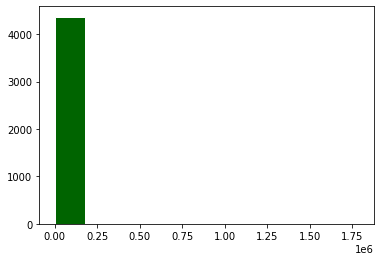

In [17]:
#plt.hist(df2.orbitperiod, color = "darkgreen", edgecolor = 'white')
plt.hist(orbper, color = "darkgreen", edgecolor = 'white')

(array([1.100e+01, 4.260e+02, 1.905e+03, 1.158e+03, 4.170e+02, 3.240e+02,
        1.140e+02, 1.400e+01, 1.000e+00, 1.000e+00]),
 array([-2.40012857, -0.7203431 ,  0.95944238,  2.63922785,  4.31901333,
         5.9987988 ,  7.67858428,  9.35836975, 11.03815523, 12.7179407 ,
        14.39772618]),
 <BarContainer object of 10 artists>)

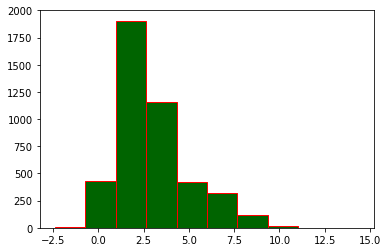

In [18]:
orbper_log = np.log(orbper)
plt.hist(orbper_log, color = "darkgreen", edgecolor = 'red')

The orbital period is skewed right, but after applying a log transform, the distribution more closely resembles a Gaussian distribution.

Going add 10 to every element in the array so as to be able to perform Log Transform on the eccentricity dataset as well.

(array([3692.,  337.,  147.,   79.,   39.,   28.,   19.,   12.,   14.,
           4.]),
 array([1.        , 1.15392828, 1.30785655, 1.46178483, 1.61571311,
        1.76964138, 1.92356966, 2.07749794, 2.23142622, 2.38535449,
        2.53928277]),
 <BarContainer object of 10 artists>)

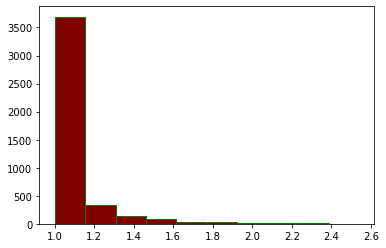

In [113]:
eccen_2 = eccen + 10
#eccen_log = np.log(eccen + 10)
#eccen_log = np.log(eccen_2)
#plt.hist(eccen_log, color = "maroon", edgecolor = 'green')
eccen_exp = np.exp(eccen)
plt.hist(eccen_exp, color = "maroon", edgecolor = 'green')

The distribution is still skewed right after applying the transform.

#### Model Building

Will implement robust scaling to deal with outliers.

As a resampling method, will use the train-test-split (tts) method. Will bundle the logic of tts into a function.

In [20]:
#def tts(data, split = 0.80):
#    train = list()
#    train_size = split*len(data)
#    data_copy = list(data)
#    while len(train) < train_size :
#        index = randrange(len(data_copy))
#        train.append(data_copy.pop(index))
#    return np.array(train), np.array(data_copy)

#X1_train, X1_test = tts(orbper_log)
#y1_train, y1_test = tts(eccen)
#y1_train, y1_test = tts(eccen_log)
#rs = RobustScaler()
#scale_X1_train = rs.fit_transform(X1_train.reshape(-1, 1))
#scale_y1_train = rs.fit_transform(y1_train.reshape(-1, 1))
#scale_X1_test = rs.fit_transform(X1_test.reshape(-1, 1))
#scale_X1_train

In [21]:
#X1_train, X1_test, y1_train, y1_test = train_test_split(np.array(orbper_log), np.array(eccen_log), train_size = 0.80, random_state = 25)
X1_train, X1_test, y1_train, y1_test = train_test_split(np.array(orbper), np.array(eccen), train_size = 0.80, random_state = 25)

Will change the central tendency metric from median to mean to get a better R-squared metric.

In [22]:
y_baseline = y1_train.mean()
#y_baseline = statistics.median(y1_train)
y_baseline

0.0637315305801972

In [23]:
y_pred_train = [y_baseline] * len(y1_train)

In [24]:
# Following is for the Training Dataset.
# Error for training data baseline guess.
mae_train_1 = mean_absolute_error(y1_train, y_pred_train)
print(f'Traing Set Mean Absolute Error: {mae_train_1}')
# Mean squared error for training data baseline guess.
mse_train_1 = mean_squared_error(y1_train, y_pred_train)
print(f'Traing Set Mean Squared Error: {mse_train_1}')
rmse_train_1 = sqrt(mse_train_1) # <- will compute the root mean square error
print(f'Traing Set Root Mean Square Error: {rmse_train_1}')
# R-squared for training data baseline guess.
y1_train_r2 = r2_score(y1_train, y_pred_train)
print(f'Traing Set R2: {y1_train_r2}')

Traing Set Mean Absolute Error: 0.08752901986553943
Traing Set Mean Squared Error: 0.01788375152612843
Traing Set Root Mean Square Error: 0.13373014441825906
Traing Set R2: 0.0


In [25]:
y_pred_test = [y_baseline] * len(y1_test)

In [26]:
# Error for test data baseline guess.
mae_test_1 = mean_absolute_error(y1_test, y_pred_test)
print(f'Test Set Mean Absolute Error: {mae_test_1}')
# Mean squared error for test data baseline guess.
mse_test_1 = mean_squared_error(y1_test, y_pred_test)
print(f'Test Set Mean Squared Error: {mse_test_1}')
rmse_test_1 = sqrt(mse_test_1) # <- will compute the root mean square error
print(f'Test Set Root Mean Square Error: {rmse_test_1}')
# R-squared for test data baseline guess.
y1_test_r2 = r2_score(y1_test, y_pred_test)
print(f'Test Set R2: {y1_test_r2}')

Test Set Mean Absolute Error: 0.09067568318514926
Test Set Mean Squared Error: 0.019771780663498325
Test Set Root Mean Square Error: 0.14061216399550333
Test Set R2: -9.981601752739877e-05


In [27]:
prediction_1 = pd.DataFrame(['Baseline', mae_train_1, mse_train_1, rmse_train_1, y1_train_r2, mae_test_1, mse_test_1, rmse_test_1, y1_test_r2]).T
metric_col_names = ['Method', 'Train MAE', 'Train MSE', 'Train RMSE', 'Train R2', 'Test MAE', 'Test MSE','Test RMSE', 'Test R2'] # <- This list will be used over so easier to store in variable.
prediction_1.columns = metric_col_names
prediction_1

,Method,Train MAE,Train MSE,Train RMSE,Train R2,Test MAE,Test MSE,Test RMSE,Test R2
0,Baseline,0.087529,0.017884,0.13373,0.0,0.090676,0.019772,0.140612,-0.0001


Now to apply the logarithmic and exponential transformations to the variables I chose.

In [121]:
X1_train_log = np.log10(X1_train)
X1_test_log = np.log10(X1_test)
#y1_train_log = np.log(y1_train + 10) # <- Remember to add 10 units to be able apply log transform
y1_train_exp = np.exp(y1_train)
y1_test_exp = np.exp(y1_test)

With the data scaled using aforementioned trasnformations, will now test various k's for best fit. Will run kNN for various values of n_neighbors and store results. This will help me determine optimal 'k'.

In [150]:
# kNN R-squared accuracy
knn_r_acc_1 = []
for i1 in range(1, 75, 1):
    knn = KNeighborsRegressor(n_neighbors = i1)
    knn.fit(X1_train_log.reshape(-1, 1), y1_train.reshape(-1, 1))
    test_score_1 = knn.score(X1_test_log.reshape(-1, 1), y1_test.reshape(-1, 1))
    train_score_1 = knn.score(X1_train_log.reshape(-1, 1), y1_train.reshape(-1, 1))
    knn_r_acc_1.append((i1, test_score_1, train_score_1))
outcomes_1 = pd.DataFrame(knn_r_acc_1, columns = ['k', 'Test Score', 'Train Score'])
print(outcomes_1)
print('The highest Test R-squared value occurs at : %.4f' % outcomes_1.iloc[:,1].max())
print('Within given range, optimal k is: ', outcomes_1.loc[outcomes_1['Test Score'] == outcomes_1.iloc[:,1].max(), 'k'].iloc[0])

     k  Test Score  Train Score
0    1   -0.376242     0.999928
1    2   -0.008741     0.670980
2    3    0.094896     0.545762
3    4    0.148759     0.490142
4    5    0.189452     0.456295
..  ..         ...          ...
69  70    0.352576     0.321298
70  71    0.351332     0.320772
71  72    0.350412     0.320366
72  73    0.350777     0.319908
73  74    0.350296     0.320097

[74 rows x 3 columns]
The highest Test R-squared value occurs at : 0.3530
Within given range, optimal k is:  64


In [152]:
model_knn_1 = KNeighborsRegressor(n_neighbors = 64)
model_knn_1.fit(X1_train_log.reshape(-1, 1), y1_train.reshape(-1, 1))
y_knn_train_pred_log_1 = model_knn_1.predict(X1_train_log.reshape(-1, 1))
y_knn_test_pred_log_1 = model_knn_1.predict(X1_test_log.reshape(-1, 1))

In [153]:
# Following line to remind myself that values between 0 - 1 will produce negative value in log.
np.log(0.055550)

-2.890471762896498

In [154]:
# Following logic 
#y_knn_train_pred_1 = np.exp(y_knn_train_pred_log_1)
#y_knn_train_pred_1 = np.power(y_knn_train_pred_log_1, 10)
y_knn_train_pred_1 = y_knn_train_pred_log_1
#y_knn_test_pred_1 = np.log(y_knn_test_pred_log_1) 
#y_knn_test_pred_1 = np.power(y_knn_test_pred_log_1, 10)
y_knn_test_pred_1 = y_knn_test_pred_log_1
#y_knn_test_pred_1 = np.exp(y_knn_test_pred_log_1) 

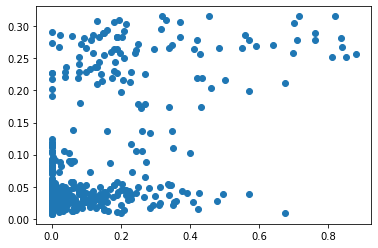

In [155]:
plt.scatter(y1_test, y_knn_test_pred_1)

Trying to avoid data leakage when going from transform to inverse.

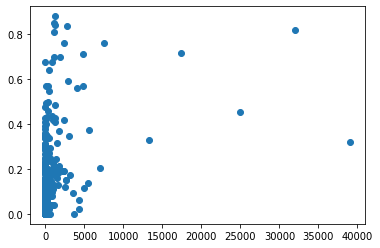

In [156]:
plt.scatter(X1_test, y1_test)

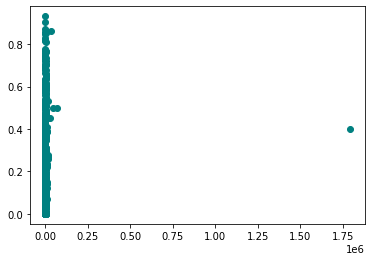

In [157]:
plt.scatter(X1_train, y1_train, c = "teal")

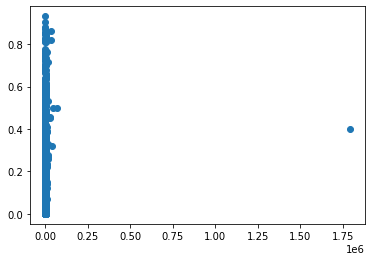

In [158]:
plt.scatter(orbper, eccen)

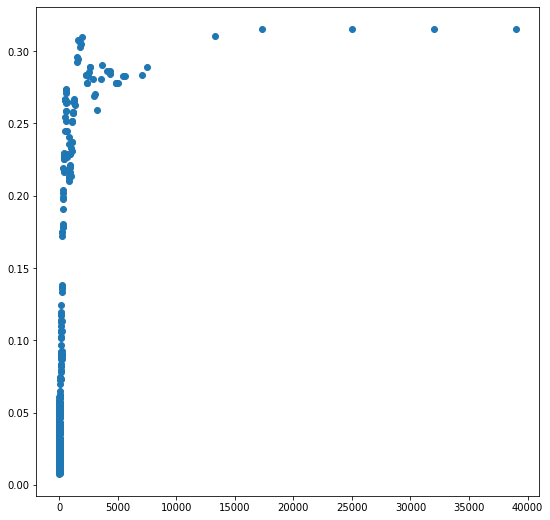

In [159]:
# Following to 'unscale' the fitted data
# The y-values are the actual test data.
#inverse_X1test = np.exp(X1_test)
#inverse_knn_model_1 = np.exp(y_knn_test_pred_1)
plt.figure(figsize = (9, 9))
#plt.scatter(inverse_X1test, y1_test)
plt.scatter(X1_test, y_knn_test_pred_1)

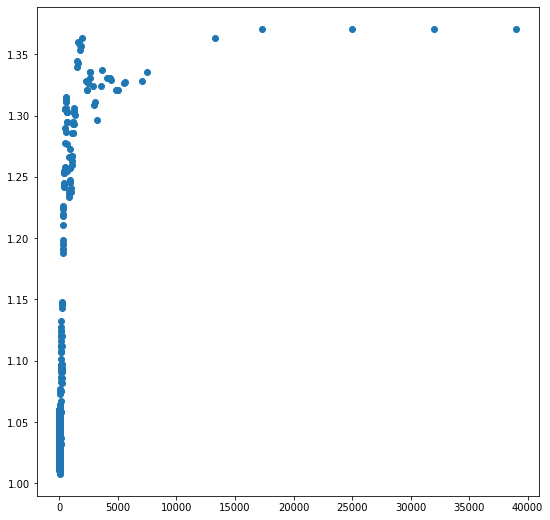

In [160]:
plt.figure(figsize = (9, 9))
plt.scatter(X1_test, np.exp(y_knn_test_pred_1))
#plt.scatter(inverse_X1test, inverse_knn_model_1)

C:\Users\joepb\AppData\Local\Temp\ipykernel_7592\3129027379.py:2: RuntimeWarning: overflow encountered in exp
  plt.scatter(np.exp(X1_test), np.exp(y_knn_test_pred_1))


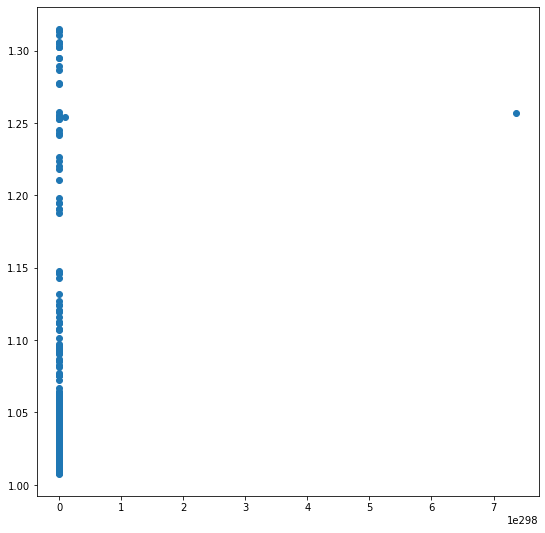

In [161]:
plt.figure(figsize = (9, 9))
plt.scatter(np.exp(X1_test), np.exp(y_knn_test_pred_1))

Want to make a quick calculation of the residuals in this prediction and actual values evaluation.

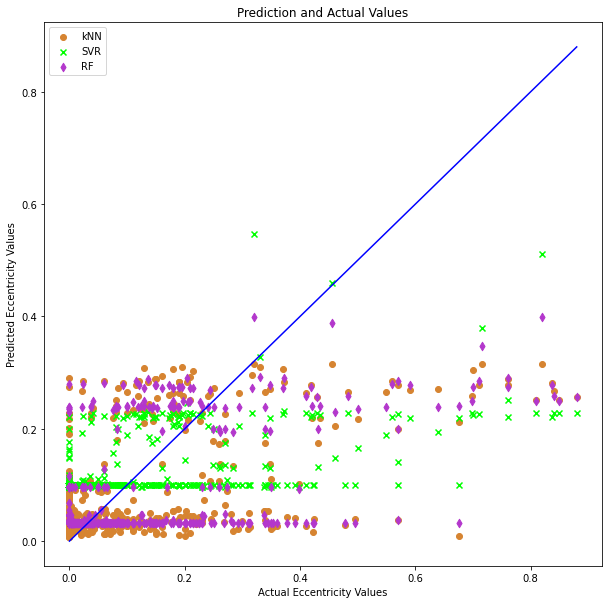

In [208]:
 rue_values_1 = y1_test
predicted_values1_1 = y_knn_test_pred_1
predicted_values1_2 = y_svr_test_pred_1
predicted_values1_3 = y_rf_test_pred_1

plt.figure(figsize = (10, 10))
# kNN model
knn_1 = plt.scatter(x = true_values_1, y = predicted_values1_1, c = '#d68431')
# SVR model
svr_1 = plt.scatter(x = true_values_1, y = predicted_values1_2, c = 'lime', marker = 'x')
# Random Forest model
rf_1 = plt.scatter(x = true_values_1, y = predicted_values1_3, c = '#b337cc', marker = 'd')
p1 = max(max(predicted_values1_1), max(predicted_values1_2), max(predicted_values1_3), max(true_values_1))
p2 = min(min(predicted_values1_1), min(predicted_values1_2), min(predicted_values1_3), min(true_values_1))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.title('Prediction and Actual Values')
plt.xlabel('Actual Eccentricity Values')
plt.ylabel('Predicted Eccentricity Values')
plt.legend([knn_1, svr_1, rf_1], ['kNN', 'SVR', 'RF'], loc = 'upper left')
plt.savefig('output_1.png')
plt.show()

Want to plot the residuals and see if there are any obvious patterns. Another name is the Versus Fit.

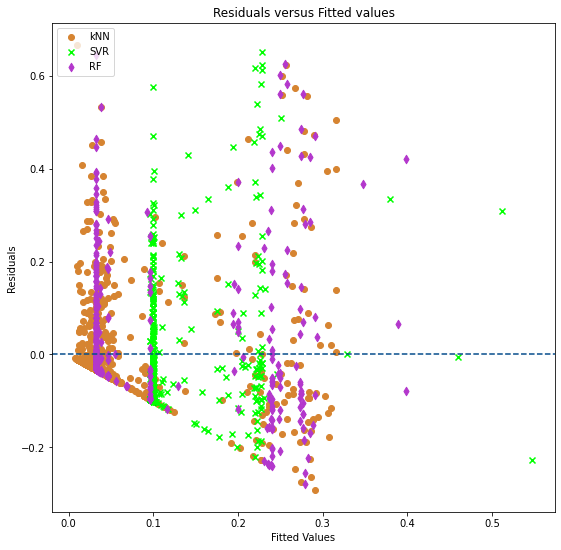

In [209]:
# Will invoke for loop to calculate residulas for the three different models.
residuals1_1 = list()
for item1, item2 in zip(true_values_1, predicted_values1_1):
    residuals1_1.append(item1 - item2)
residuals1_2 = list()
for item3, item4 in zip(true_values_1, predicted_values1_2):
    residuals1_2.append(item3 - item4)
residuals1_3 = list()
for item5, item6 in zip(true_values_1, predicted_values1_3):
    residuals1_3.append(item5 - item6)

plt.figure(figsize = (9, 9))
# kNN model
knn_resid_1 = plt.scatter(x = predicted_values1_1, y = residuals1_1, c = '#d68431')
# SVR model
svr_resid_1 = plt.scatter(x = predicted_values1_2, y = residuals1_2, c = 'lime', marker = 'x')
# Random Forest model
rf_resid_1 = plt.scatter(x = predicted_values1_3, y = residuals1_3, c = '#b337cc', marker = 'd')

plt.title('Residuals versus Fitted values')
plt.xlabel('Fitted Values') # <- Predicted Values
plt.ylabel('Residuals')
plt.legend([knn_resid_1, svr_resid_1, rf_resid_1], ['kNN', 'SVR', 'RF'], loc = 'upper left')
plt.axhline(y = 0.0, color = '#034b8a', linestyle = '--')
plt.savefig('output_2.png')
plt.show()

There is an obvious pattern in the residuals plot.

In [164]:
# First the training metrics.
knn1_train_mae = mean_absolute_error(y1_train, y_knn_train_pred_1)
knn1_train_mse = mean_squared_error(y1_train, y_knn_train_pred_1)
knn1_train_rmse = sqrt(knn1_train_mse) # <- will compute the root mean square error
knn1_train_r2 = r2_score(y1_train, y_knn_train_pred_1)
# Now, test set metrics.
knn1_test_mae = mean_absolute_error(y1_test, y_knn_test_pred_1)
knn1_test_mse = mean_squared_error(y1_test, y_knn_test_pred_1)
knn1_test_rmse = sqrt(knn1_test_mse)
knn1_test_r2 = r2_score(y1_test, y_knn_test_pred_1)
# Consolidate the results.
knn_results_1 = pd.DataFrame(['k Nearest Neighbor', knn1_train_mae, knn1_train_mse, knn1_train_rmse, knn1_train_r2, knn1_test_mae, knn1_test_mse, knn1_test_rmse, knn1_test_r2]).transpose()
knn_results_1.columns = metric_col_names
knn_results_1

,Method,Train MAE,Train MSE,Train RMSE,Train R2,Test MAE,Test MSE,Test RMSE,Test R2
0,k Nearest Neighbor,0.066004,0.01209,0.109954,0.32398,0.067364,0.012791,0.113099,0.352987


#### SVR regressor model.

In [166]:
svr_regressor_1 = SVR(kernel = 'rbf')
svr_regressor_1.fit(X1_train_log.reshape(-1, 1), y1_train.reshape(-1, 1))
y_svr_train_pred_1 = svr_regressor_1.predict(X1_train_log.reshape(-1, 1))
y_svr_test_pred_1 = svr_regressor_1.predict(X1_test_log.reshape(-1, 1))
# Model performance - training set
svr1_train_mae = mean_absolute_error(y1_train, y_svr_train_pred_1)
svr1_train_mse = mean_squared_error(y1_train, y_svr_train_pred_1)
svr1_train_rmse = sqrt(svr1_train_mse)
svr1_train_r2 = r2_score(y1_train, y_svr_train_pred_1)
# Test results
svr1_test_mae = mean_absolute_error(y1_test, y_svr_test_pred_1)
svr1_test_mse = mean_squared_error(y1_test, y_svr_test_pred_1)
svr1_test_rmse = sqrt(svr1_test_mse)
svr1_test_r2 = r2_score(X1_test, y_svr_test_pred_1)
# Consolidate the results.
#svr_results = pd.DataFrame(['SVR', svr_train_mse, svr_train_r2, svr_test_mse, svr_test_r2]).T
svr_results_1 = pd.DataFrame(['SVR', svr1_train_mae, svr1_train_mse, svr1_train_rmse, svr1_train_r2, svr1_test_mae, svr1_test_mse, svr1_test_rmse, svr1_test_r2]).T
svr_results_1.columns = metric_col_names
#results2 = pd.concat([knn_results, svr_results.T], ignore_index = False)
#print(results2)
#print(svr_results_1)
svr_results_1

c:\users\joepb\miniconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Method,Train MAE,Train MSE,Train RMSE,Train R2,Test MAE,Test MSE,Test RMSE,Test R2
0,SVR,0.104178,0.016254,0.127492,0.091116,0.10604,0.016782,0.129544,-0.025504


Now want to model using the Random Forest Regressor.

In [167]:
rf_1 = RandomForestRegressor(max_depth=2)
rf_1.fit(X1_train_log.reshape(-1, 1), y1_train.reshape(-1, 1))
y_rf_train_pred_1 = rf_1.predict(X1_train_log.reshape(-1, 1))
y_rf_test_pred_1 = rf_1.predict(X1_test_log.reshape(-1, 1))
rf_1

C:\Users\joepb\AppData\Local\Temp\ipykernel_7592\4240487719.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_1.fit(X1_train_log.reshape(-1, 1), y1_train.reshape(-1, 1))


RandomForestRegressor(max_depth=2)

In [168]:
# Model performance metrics for random forest model.
rf1_train_mae = mean_absolute_error(y1_train, y_rf_train_pred_1)
rf1_train_mse = mean_squared_error(y1_train, y_rf_train_pred_1)
rf1_train_rmse = sqrt(rf1_train_mse)
rf1_train_r2 = r2_score(y1_train, y_rf_train_pred_1)
# The following are the test metrics.
rf1_test_mae = mean_absolute_error(y1_test, y_rf_test_pred_1)
rf1_test_mse = mean_squared_error(y1_test, y_rf_test_pred_1)
rf1_test_rmse = sqrt(rf1_test_mse)
rf1_test_r2 = r2_score(y1_test, y_rf_test_pred_1)

In [169]:
rf1_results = pd.DataFrame(['Random Forest', rf1_train_mae, rf1_train_mse, rf1_train_rmse, rf1_train_r2, rf1_test_mae, rf1_test_mse, rf1_test_rmse, rf1_test_r2]).transpose()
rf1_results.columns = metric_col_names
rf1_results

,Method,Train MAE,Train MSE,Train RMSE,Train R2,Test MAE,Test MSE,Test RMSE,Test R2
0,Random Forest,0.06653,0.01216,0.110273,0.320042,0.066961,0.012535,0.111958,0.365977


Want to add all the results to a single table.

In [170]:
results_1 = pd.concat([prediction_1, knn_results_1, svr_results_1, rf1_results], axis = 0, ignore_index = True)
results_1 

,Method,Train MAE,Train MSE,Train RMSE,Train R2,Test MAE,Test MSE,Test RMSE,Test R2
0,Baseline,0.087529,0.017884,0.13373,0.0,0.090676,0.019772,0.140612,-0.0001
1,k Nearest Neighbor,0.066004,0.01209,0.109954,0.32398,0.067364,0.012791,0.113099,0.352987
2,SVR,0.104178,0.016254,0.127492,0.091116,0.10604,0.016782,0.129544,-0.025504
3,Random Forest,0.06653,0.01216,0.110273,0.320042,0.066961,0.012535,0.111958,0.365977


#### Bootstrap Confidence Intervals

For this section, want to develop logic to use bootstrap method to configure confidence interval.

In [50]:
df2_log = pd.concat([np.log10(orbper), eccen], axis = 1)
df2_log

,orbitperiod,eccentricity
planetname,,
11 Com b,2.513258,0.231000
11 UMi b,2.712835,0.080000
14 And b,2.269139,0.000000
14 Her b,3.247139,0.362233
16 Cyg B b,2.902751,0.676033
...,...,...
ups And b,0.664287,0.030200
ups And c,2.381528,0.238933
ups And d,3.109020,0.281117


In [51]:
df2_log.values

array([[2.51325756, 0.231     ],
       [2.71283481, 0.08      ],
       [2.2691392 , 0.        ],
       ...,
       [3.10902011, 0.28111667],
       [2.58568628, 0.32      ],
       [2.13592734, 0.        ]])

In [52]:
type(df2_log)

pandas.core.frame.DataFrame

In [53]:
from sklearn.utils import resample
# Load data
values = df2_log.values
# Set up bootstrap
n_iters = 50
n_size = int(len(df2_log) * 0.50)
# Run bootstrap
stats = list()
for index in range(n_iters):
    # Prep train and test sets
    train = resample(values, n_samples = n_size)
    test = np.array([x for x in values if x.tolist() not in train.tolist()])
    # Fit model
    bootstrap_knn =  KNeighborsRegressor(n_neighbors = 64)
    bootstrap_knn.fit(train[:, :-1], train[:, -1])
    # Evaluate model
    predictions = bootstrap_knn.predict(test[:, :-1])
    score = mean_absolute_error(test[:, -1], predictions)
    #print(head(score))
    #print(tail(score))
    stats.append(score)
# Plot Scores
plt.hist(stats)
plt.shot()
# Confidence Interval
alpha = 0.95
p = ((1.0 - alpha)/2.0) * 100
lower = max(0.0, np.percentiles(stats, p))
p = (alpha + ((1.0 - alpha)/2.0)) * 100
upper = min(1.0, np.percentile(stats, p))
print('%.1f confidence interval %.1f% and %.1f%' % (alpha*100, lower*100, upper*100))

KeyboardInterrupt: 

In [199]:
def bootstrap_95ci_mae(data): # <- Mean Absolute Error
    # Load and transform data
    #values = data.values
    #values = data.ravel()
    values = data
    # Set up bootstrap
    bootstrap_iter = 5000
    #sample_size = int(len(data) * 0.50)
    sample_size = len(data)
    #sample_size = bootstrap_iter
    # Confidence Interval
    confidence = 0.95
    alpha_level = 0.95 * 100
    lower = ((1.0 - confidence)/2.0) * 100 # Should be 2.5 as the lower bound.
    upper = alpha_level + (((1.0 - confidence)/2.0) * 100) # Should be 97.5 as the upper bound
    # Run bootstrap
    mae_metrics = []
    #stats = list()
    for index in range(bootstrap_iter):
        #sample = resample(values, n_samples = sample_size)
        sample = resample(values, n_samples = sample_size)
        #test = np.array([x for x in values if x.tolist() not in train.tolist()])
        #r2 = r2_score(test_data, predictions)
        #r2 = r2_score(test_data, sample)
        #bootstrap_knn =  KNeighborsRegressor(n_neighbors = 64)
        #bootstrap_knn.fit(train[:, :-1], train[:, -1])
        #predictions = bootstrap_knn.predict(test[:, :-1])
        #score = mean_absolute_error(test[:, -1], predictions)
        score = mean_absolute_error(data, sample)
        mae_metrics.append(score)
        #r2_metrics.append(r2)
        #stats.append(score)
    confidence_interval = np.percentile(mae_metrics, [lower, upper])
    #plt.hist(stats)
    #plt.hist(mae_metrics)
    #plt.show()
    return plt.hist(mae_metrics, color = '#2eb3b0', edgecolor = 'black'), confidence_interval

((array([   9.,   71.,  334.,  895., 1414., 1287.,  707.,  222.,   56.,
            5.]),
  array([0.05356872, 0.05525229, 0.05693586, 0.05861943, 0.060303  ,
         0.06198657, 0.06367014, 0.0653537 , 0.06703727, 0.06872084,
         0.07040441]),
  <BarContainer object of 10 artists>),
 array([0.05728927, 0.06630552]))

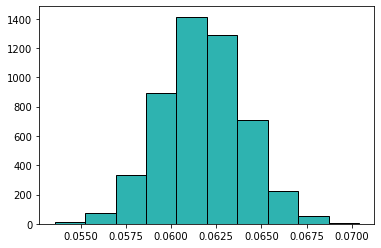

In [200]:
bootstrap_95ci_mae(y_knn_test_pred_1)

In [100]:
def ci_95_mae(test_data): # The function will be set up for a 95% confidence interval.
    bootstrap_iter = 5000
    sample_size = len(test_data)
    #sample_size = bootstrap_iter
    mae_metrics = []
    confidence = 0.95
    alpha_level = 0.95 * 100
    lower = ((1.0 - confidence)/2.0) * 100 # Should be 2.5 as the lower bound.
    upper = alpha_level + (((1.0 - confidence)/2.0) * 100) # Should be 97.5 as the upper bound
    for i in range(bootstrap_iter):
        #sample = resample(predictions, n_samples = sample_size)
        sample = resample(test_data, n_samples = sample_size)
        #r2 = r2_score(test_data, predictions)
        mae = mean_absolute_error(test_data, sample)
        mae_metrics.append(mae)
    confidence_interval = np.percentile(mae_metrics, [lower, upper])
    return mae_metrics, confidence_interval

In [101]:
a1, b1 = ci_95_mae(y_knn_test_pred_1)

In [102]:
b1

array([0.05732371, 0.06628269])

(array([   3.,   27.,  165.,  632., 1425., 1467.,  888.,  313.,   75.,
           5.]),
 array([0.05240346, 0.05419888, 0.05599431, 0.05778973, 0.05958515,
        0.06138057, 0.063176  , 0.06497142, 0.06676684, 0.06856226,
        0.07035769]),
 <BarContainer object of 10 artists>)

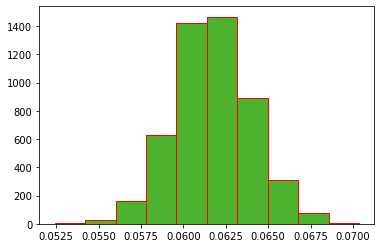

In [198]:
plt.hist(a1, color = '#4db32e', edgecolor = 'red')

In [104]:
a2, b2 = ci_95_mae(y_rf_test_pred_1)

In [105]:
b2

array([0.04952513, 0.05901313])

(array([  10.,   89.,  419., 1036., 1482., 1178.,  565.,  175.,   39.,
           7.]),
 array([0.04565786, 0.04747489, 0.04929192, 0.05110894, 0.05292597,
        0.054743  , 0.05656002, 0.05837705, 0.06019408, 0.0620111 ,
        0.06382813]),
 <BarContainer object of 10 artists>)

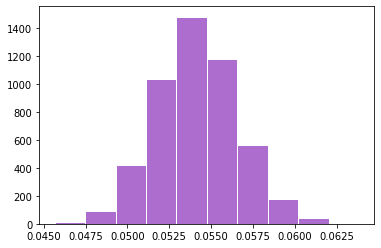

In [201]:
plt.hist(a2, color = '#ad6dcf', edgecolor = 'white')

In [107]:
a3, b3 = ci_95_mae(y1_test)

In [108]:
b3

array([0.09917254, 0.11659113])

(array([  12.,   95.,  446., 1098., 1451., 1156.,  523.,  174.,   39.,
           6.]),
 array([0.09235489, 0.09562508, 0.09889526, 0.10216544, 0.10543562,
        0.10870581, 0.11197599, 0.11524617, 0.11851635, 0.12178654,
        0.12505672]),
 <BarContainer object of 10 artists>)

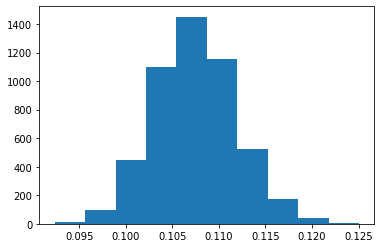

In [109]:
plt.hist(a3)

#### Hypothesis Testing

#### Correlation Tests

In [176]:
# Spearman's Rank Correlation Test
from scipy.stats import spearmanr
stat_1, p_1 = spearmanr(orbper_log, eccen)
print('stat=%.3f, p = %.3f' % (stat_1, p_1))
if p_1 > 0.05:
    print('Probably Independent')
else :
    print('Probably Dependent')

stat=0.303, p = 0.000
Probably Dependent


#### Nonparametric Statistical Hypothesis Tests

In [177]:
# Wilcoxon Signed-Rank Test
from scipy.stats import wilcoxon
stat_2, p_2 = wilcoxon(orbper_log, eccen)
print('stat=%.3f, p = %.3f' % (stat_2, p_2))
if p_2 > 0.05:
    print('Probably Independent')
else :
    print('Probably Dependent')

stat=17028.000, p = 0.000
Probably Dependent


### Scenario 2 - temperature as function of planet size

Now want to begin analysis of equilibrium temperature as a function of planet size.

In [ ]:
df3 = raw_data.loc[:, ['pl_name','pl_bmassj','pl_eqt']]
df3

In [ ]:
df3 = df3.rename(columns={'pl_name':'planetname', 'pl_bmassj':'mass', 'pl_eqt':'temperature'})
df3 = df3.dropna()
df3

In [ ]:
mass = df3.groupby('planetname')['mass'].mean()
temp = df3.groupby('planetname')['temperature'].mean()

In [ ]:
print(mass)
print(temp)

In [ ]:
plt.scatter(mass, np.log(temp))

Want some summary statistics for the new two variables.

In [ ]:
mass_med = statistics.median(list(mass))
temp_med = statistics.median(list(temp))
print('\nThe median mass: %.4f' % mass_med)
print('\nThe median temperature: %.2f' % temp_med)
iqr_mass = stats.iqr(mass, interpolation = 'midpoint')
iqr_temp = stats.iqr(temp, interpolation = 'midpoint')
print('\nThe interquartile range of the mass: %.2f' % iqr_mass)
print('\nThe interquartile range of the temperature: %.2f' % iqr_temp)
mass_mode = statistics.mode(list(mass))
print('\nThe mode for the mass: %.2f' % mass_mode)
temp_mode = statistics.mode(list(temp))
print('\nThe mode for the temperature: %.2f' % temp_mode)
mass_avg = statistics.mean(list(mass))
print('\nThe mean for the mass: %.2f' % mass_avg)
temp_avg = statistics.mean(list(temp))
print('\nThe mean for the planetary temperature: %.2f' % temp_avg)

In [ ]:
plt.hist(mass, color = "blueviolet", edgecolor = 'white')

In [ ]:
mass_log = np.log10(mass)
plt.hist(mass_log, color = "blueviolet", edgecolor = 'red')

The distribution became more normally distributed when applying the log base 10 transformation on the dataset.

In [ ]:
plt.hist(temp, color = "teal", edgecolor = 'white')

In [ ]:
temp_log = np.log10(temp)
plt.hist(temp_log, color = "teal", edgecolor = 'red')

In this case, the dataset became skew left when the logarithmic transformation was applied.

Will now split the data into their respective sets.

In [ ]:
X2 = np.array(mass).reshape(-1,1)
y2 = np.array(temp).reshape(-1, 1)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, train_size = 0.80, random_state = 25)
y2_train = y2_train.reshape(len(y2_train), )
y2_test = y2_test.reshape(len(y2_test), )

In [ ]:
# Establishing baselines for predictions according to the y-variable or response variable.
y_baseline_2= y2_train.mean()
#y_baseline_2= statistics.median(y2_train)
y_pred_train_2 = [y_baseline_2]*len(y2_train) #<- Training Baseline
y_pred_test_2 = [y_baseline_2]*len(y2_test)

In [ ]:
# Following is for the Training Dataset.
# Error for training data baseline guess.
mae_train_2 = mean_absolute_error(y2_train, y_pred_train_2)
# Mean squared error for training data baseline guess.
mse_train_2 = mean_squared_error(y2_train, y_pred_train_2)
rmse_train_2 = sqrt(mse_train_2) # <- will compute the root mean square error
# R-squared for training data baseline guess.
y2_train_r2 = r2_score(y2_train, y_pred_train_2)

In [ ]:
# Error for test data baseline guess.
mae_test_2 = mean_absolute_error(y2_test, y_pred_test_2)
# Mean squared error for test data baseline guess.
mse_test_2 = mean_squared_error(y2_test, y_pred_test_2)
# Test Root Mean Square Error
rmse_test_2 = sqrt(mse_test_2)
# R-squared for test data baseline guess.
y2_test_r2 = r2_score(y2_test, y_pred_test_2)

In [ ]:
baseline_2 = pd.DataFrame(['Baseline', mae_train_2, mse_train_2, rmse_train_2, y2_train_r2, mae_test_2, mse_test_2, rmse_test_2, y2_test_r2]).T
baseline_2.columns = metric_col_names
baseline_2

Recall that the response variable (y) in this case is the mass of the planet (in Jupiter masses) which needs the log base 10 transform.

In [ ]:
X2_train_log, X2_test_log = np.log10(X2_train), np.log10(X2_test)
y2_train_log = np.log10(y2_train)

In [ ]:
# kNN R-squared accuracy
knn_r_acc_2 = []
for j in range(1, 75, 1):
    knn_2 = KNeighborsRegressor(n_neighbors = j)
    knn_2.fit(X2_train_log.reshape(-1, 1), y2_train_log.reshape(-1, 1))
    test_score_2 = knn_2.score(X2_test_log.reshape(-1, 1), np.log10(y2_test))
    train_score_2 = knn_2.score(X2_train_log.reshape(-1, 1), y2_train_log.reshape(-1, 1))
    knn_r_acc_2.append((j, test_score_2, train_score_2))
outcomes_2 = pd.DataFrame(knn_r_acc_2, columns = ['k', 'Test Score', 'Train Score'])
print(outcomes_2)
print('The highest Test R-squared value occurs at : %.4f' % outcomes_2.iloc[:,1].max())
print('Within given range, optimal k is: ', outcomes_2.loc[outcomes_2['Test Score'] == outcomes_2.iloc[:,1].max(), 'k'].iloc[0])

In [ ]:
model_knn_2 = KNeighborsRegressor(n_neighbors = 40)
model_knn_2.fit(X2_train_log.reshape(-1, 1), y2_train_log.reshape(-1, 1))
y_knn_train_pred_2_log = model_knn_2.predict(X2_train_log.reshape(-1, 1))
y_knn_test_pred_2_log = model_knn_2.predict(X2_test_log.reshape(-1, 1))

In [ ]:
y_knn_train_pred_2 = pow(10, y_knn_train_pred_2_log)
#y_knn_train_pred_2 = y_knn_train_pred_2_log
y_knn_test_pred_2 = pow(10, y_knn_test_pred_2_log)
#y_knn_test_pred_2 = y_knn_test_pred_2_log
#X2_inverse = pow(10, y_knn_test_pred_2_log) #<- Will cause runtime error that is overflow in power function.

In [ ]:
# First the training metrics.
knn2_train_mae = mean_absolute_error(y2_train, y_knn_train_pred_2)
knn2_train_mse = mean_squared_error(y2_train, y_knn_train_pred_2)
knn2_train_rmse = sqrt(knn2_train_mse) # <- will compute the root mean square error
knn2_train_r2 = r2_score(y2_train, y_knn_train_pred_2)
# Now, test set metrics.
knn2_test_mae = mean_absolute_error(y2_test, y_knn_test_pred_2)
knn2_test_mse = mean_squared_error(y2_test, y_knn_test_pred_2)
knn2_test_rmse = sqrt(knn2_test_mse)
knn2_test_r2 = r2_score(y2_test, y_knn_test_pred_2)
# Consolidate the results.
knn_results_2 = pd.DataFrame(['k Nearest Neighbor', knn2_train_mae, knn2_train_mse, knn2_train_rmse, knn2_train_r2, knn2_test_mae, knn2_test_mse, knn2_test_rmse, knn2_test_r2]).transpose()
knn_results_2.columns = metric_col_names
knn_results_2

In [ ]:
plt.hist(y_knn_test_pred_2, color = "teal", edgecolor = 'white')

Now, want the true versus the predicted values.

In [ ]:
true_values_2 = y2_test
predicted_values2_1 = y_knn_test_pred_2
plt.figure(figsize = (6, 6))
plt.scatter(true_values_2, predicted_values2_1, c = 'orange')
p3 = max(max(predicted_values2_1), max(true_values_2))
p4 = min(min(predicted_values2_1), min(true_values_2))
plt.plot([p3, p4], [p3, p4], 'b-')
plt.show()

In [ ]:
residuals2_1 = list()
for item5, item6 in zip(true_values_2, predicted_values2_1):
    residuals2_1.append(item6 - item5)
resid_plot1 = plt.scatter(predicted_values2_1, residuals2_1, c = 'green')
plt.show(resid_plot1)

In [ ]:
# basic scatterplot to visualize the data.
# Remember to only use training data since will use to train model.
#plt.scatter(np.log10(X2_train), np.log10(y2_train))
plt.scatter(y2_train, X2_train)

Now to build Support Vector Regressor model.

In [ ]:
X2_train_log = X2_train_log.reshape(-1,1)
X2_test_log = X2_test_log.reshape(-1,1)
y2_train_log = y2_train_log.reshape(-1,1)

eps = 8
svr_2 = SVR(kernel = 'rbf', C = 1000, epsilon = eps)
svr_2.fit(X2_train_log, y2_train_log)

#y_svr_train_pred_2 = svr_regressor_2.predict(X2_train)
y_svr_train_pred_2_log = svr_2.predict(X2_train_log)
#y_svr_test_pred_2 = svr_regressor_2.predict(X2_test)
y_svr_test_pred_2_log = svr_2.predict(X2_test_log)
y_svr_train_pred_2 = pow(10, y_svr_train_pred_2_log)
y_svr_test_pred_2 = pow(10, y_svr_test_pred_2_log)

In [ ]:
# Model performance - training set
svr2_train_mae = mean_absolute_error(y2_train, y_svr_train_pred_2_log)
svr2_train_mse = mean_squared_error(y2_train, y_svr_train_pred_2_log)
svr2_train_rmse = sqrt(svr2_train_mse)
svr2_train_r2 = r2_score(y2_train, y_svr_train_pred_2_log)
# Test results
svr2_test_mae = mean_absolute_error(y2_test, y_svr_test_pred_2_log)
svr2_test_mse = mean_squared_error(y2_test, y_svr_test_pred_2_log)
svr2_test_rmse = sqrt(svr2_test_mse)
svr2_test_r2 = r2_score(X2_test, y_svr_test_pred_2_log)
# Consolidate the results.
#svr_results = pd.DataFrame(['SVR', svr_train_mse, svr_train_r2, svr_test_mse, svr_test_r2]).T
svr_results_2 = pd.DataFrame(['SVR', svr2_train_mae, svr2_train_mse, svr2_train_rmse, svr2_train_r2, svr2_test_mae, svr2_test_mse, svr2_test_rmse, svr2_test_r2]).T
svr_results_2.columns = metric_col_names
#results2 = pd.concat([knn_results, svr_results.T], ignore_index = False)
#print(results2)
#print(svr_results_1)
svr_results_2

In [ ]:
true_values_2 = y2_test
predicted_values2_2 = y_svr_test_pred_2
plt.figure(figsize = (6, 6))
plt.scatter(true_values_2, predicted_values2_2, c = 'orange')
p5 = max(max(predicted_values2_2), max(true_values_2))
p6 = min(min(predicted_values2_2), min(true_values_2))
plt.plot([p5, p6], [p5, p6], 'b-')
plt.show()

In [ ]:
residuals2_2 = list()
for item3, item4 in zip(true_values_2, predicted_values2_2):
    residuals2_2.append(item3 - item4)
plt.scatter(predicted_values2_2, residuals2_2, c = 'green')

In [ ]:
rf_2 = RandomForestRegressor(max_depth = 2)
rf_2.fit(X2_train_log, y2_train_log)
y_rf_train_pred_2_log = rf_2.predict(X2_train_log)
y_rf_test_pred_2_log = rf_2.predict(X2_test_log)
rf_2

In [ ]:
y_rf_train_pred_2 = pow(10, y_rf_train_pred_2_log)
y_rf_test_pred_2 = pow(10, y_rf_test_pred_2_log)
# Model performance metrics for random forest model.
rf2_train_mae = mean_absolute_error(y2_train, y_rf_train_pred_2)
rf2_train_mse = mean_squared_error(y2_train, y_rf_train_pred_2)
rf2_train_rmse = sqrt(rf2_train_mse)
rf2_train_r2 = r2_score(y2_train, y_rf_train_pred_2)
# The following are the test metrics.
rf2_test_mae = mean_absolute_error(y2_test, y_rf_test_pred_2)
rf2_test_mse = mean_squared_error(y2_test, y_rf_test_pred_2)
rf2_test_rmse = sqrt(rf2_test_mse)
rf2_test_r2 = r2_score(y2_test, y_rf_test_pred_2)

In [ ]:
rf2_results = pd.DataFrame(['Random Forest', rf2_train_mae, rf2_train_mse, rf2_train_rmse, rf2_train_r2, rf2_test_mae, rf2_test_mse, rf2_test_rmse, rf2_test_r2]).transpose()
rf2_results.columns = metric_col_names
rf2_results

In [ ]:
results_2 = pd.concat([baseline_2, knn_results_2, svr_results_2, rf2_results], axis = 0, ignore_index = True)
results_2 

In [ ]:
df4 = raw_data.loc[:, ['pl_name','pl_bmassj','pl_orbper']]
df4

In [ ]:
df4 = df4.rename(columns={'pl_name':'planetname', 'pl_bmassj':'mass', 'pl_orbper':'orbit period'})
df4 = df4.dropna()
df4

In [ ]:
mass_2 = df4.groupby('planetname')['mass'].mean()
orbper_2 = df4.groupby('planetname')['orbit period'].mean()

Now some summary statistics for this scenario.

In [ ]:
mass2_med = statistics.median(list(mass_2))
orbper2_med = statistics.median(list(orbper_2))
print('\nThe median of the orbital period: %.4f' % orbper_med)
print('\nThe median of the mass: %.2f' % mass2_med)
iqr_mass2 = stats.iqr(mass_2, interpolation = 'midpoint')
iqr_orbper2 = stats.iqr(orbper_2, interpolation = 'midpoint')
print('\nThe interquartile range of the mass: %.2f' % iqr_mass2)
print('\nThe interquartile range of the orbital period: %.2f' % iqr_orbper2)
mass2_mode = statistics.mode(list(mass_2))
print('\nThe mode for the mass: %.2f' % mass2_mode)
orbper2_mode = statistics.mode(list(orbper_2))
print('\nThe mode for the orbital period: %.2f' % orbper2_mode)
mass2_avg = statistics.mean(list(mass_2))
print('\nThe mean for the mass: %.2f' % eccen_avg)
orbper2_avg = statistics.mean(list(orbper_2))
print('\nThe mean for the orbital period: %.2f' % orbper2_avg)

In [ ]:
plt.hist(mass_2, color = "darkslategray", edgecolor = 'red')

In [ ]:
plt.hist(np.log10(mass_2), color = "darkslategray", edgecolor = 'red')

In [ ]:
plt.hist(np.log(mass_2), color = "darkslategray", edgecolor = 'red')

In [ ]:
plt.hist(orbper_2, color = "salmon", edgecolor = "yellowgreen")

In [ ]:
plt.hist(np.log10(orbper_2), color = "salmon", edgecolor = "yellowgreen")

In [ ]:
y3 = np.array(mass_2).reshape(-1, 1)
X3 = np.array(orbper_2).reshape(-1, 1)
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, train_size = 0.80, random_state = 25)
y3_train = y3_train.reshape(len(y3_train), )
y3_test = y3_test.reshape(len(y3_test), )

Establishing baselines for predictions according to the y-variable or response variable.

In [ ]:
y_baseline_3= y3_train.mean()
#y_baseline_2= statistics.median(y2_train)
y_pred_train_3 = [y_baseline_3]*len(y3_train) # <- Training Baseline
y_pred_test_3 = [y_baseline_3]*len(y3_test)

In [ ]:
# Following is for the Training Dataset.
# Error for training data baseline guess.
mae_train_3 = mean_absolute_error(y3_train, y_pred_train_3)
# Mean squared error for training data baseline guess.
mse_train_3 = mean_squared_error(y3_train, y_pred_train_3)
rmse_train_3 = sqrt(mse_train_3) # <- will compute the root mean square error
# R-squared for training data baseline guess.
y3_train_r2 = r2_score(y3_train, y_pred_train_3)

In [ ]:
# Error for test data baseline guess.
mae_test_3 = mean_absolute_error(y3_test, y_pred_test_3)
# Mean squared error for test data baseline guess.
mse_test_3 = mean_squared_error(y3_test, y_pred_test_3)
# Test Root Mean Square Error
rmse_test_3 = sqrt(mse_test_3)
# R-squared for test data baseline guess.
y3_test_r2 = r2_score(y3_test, y_pred_test_3)

In [ ]:
baseline_3 = pd.DataFrame(['Baseline', mae_train_3, mse_train_3, rmse_train_3, y3_train_r2, mae_test_3, mse_test_3, rmse_test_3, y3_test_r2]).T
baseline_3.columns = metric_col_names
baseline_3

In [ ]:
X3_train_log, X3_test_log = np.log10(X3_train), np.log10(X3_test)
y3_train_log = np.log10(y3_train)

In [ ]:
# kNN R-squared accuracy
knn_r_acc_3 = []
for k in range(1, 75, 1):
    knn_3 = KNeighborsRegressor(n_neighbors = k)
    knn_3.fit(X3_train_log.reshape(-1, 1), y3_train_log.reshape(-1, 1))
    test_score_3 = knn_3.score(X3_test_log.reshape(-1, 1), np.log10(y3_test))
    train_score_3 = knn_3.score(X3_train_log.reshape(-1, 1), y3_train_log.reshape(-1, 1))
    knn_r_acc_3.append((k, test_score_3, train_score_3))
outcomes_3 = pd.DataFrame(knn_r_acc_3, columns = ['k', 'Test Score', 'Train Score'])
print(outcomes_3)
print('The highest Test R-squared value occurs at : %.4f' % outcomes_3.iloc[:,1].max())
print('Within given range, optimal k is: ', outcomes_3.loc[outcomes_3['Test Score'] == outcomes_3.iloc[:,1].max(), 'k'].iloc[0])

In [ ]:
model_knn_3 = KNeighborsRegressor(n_neighbors = 32)
model_knn_3.fit(X3_train_log.reshape(-1, 1), y3_train_log.reshape(-1, 1))
y_knn_train_pred_3_log = model_knn_3.predict(X3_train_log.reshape(-1, 1))
y_knn_test_pred_3_log = model_knn_3.predict(X3_test_log.reshape(-1, 1))

In [ ]:
y_knn_train_pred_3 = pow(10, y_knn_train_pred_3_log)
y_knn_test_pred_3 = pow(10, y_knn_test_pred_3_log)

In [ ]:
# First the training metrics.
knn3_train_mae = mean_absolute_error(y3_train, y_knn_train_pred_3)
knn3_train_mse = mean_squared_error(y3_train, y_knn_train_pred_3)
knn3_train_rmse = sqrt(knn3_train_mse) # <- will compute the root mean square error
knn3_train_r2 = r2_score(y3_train, y_knn_train_pred_3)
# Now, test set metrics.
knn3_test_mae = mean_absolute_error(y3_test, y_knn_test_pred_3)
knn3_test_mse = mean_squared_error(y3_test, y_knn_test_pred_3)
knn3_test_rmse = sqrt(knn3_test_mse)
knn3_test_r2 = r2_score(y3_test, y_knn_test_pred_3)
# Consolidate the results.
knn_results_3 = pd.DataFrame(['k Nearest Neighbor', knn3_train_mae, knn3_train_mse, knn3_train_rmse, knn3_train_r2, knn3_test_mae, knn3_test_mse, knn3_test_rmse, knn3_test_r2]).transpose()
knn_results_3.columns = metric_col_names
knn_results_3

Now to create the SVR model 3.

In [ ]:
eps_3 = 6
svr_3 = SVR(kernel = 'rbf', C = 100, epsilon = eps_3)
svr_3.fit(X3_train_log, y3_train_log)

y_svr_train_pred_3_log = svr_3.predict(X3_train_log)
y_svr_test_pred_3_log = svr_3.predict(X3_test_log)
y_svr_train_pred_3 = pow(10, y_svr_train_pred_3_log)
y_svr_test_pred_3 = pow(10, y_svr_test_pred_3_log)

In [ ]:
# Model performance - training set
svr3_train_mae = mean_absolute_error(y3_train, y_svr_train_pred_3)
svr3_train_mse = mean_squared_error(y3_train, y_svr_train_pred_3)
svr3_train_rmse = sqrt(svr3_train_mse)
svr3_train_r2 = r2_score(y3_train, y_svr_train_pred_3)
# Test results
svr3_test_mae = mean_absolute_error(y3_test, y_svr_test_pred_3)
svr3_test_mse = mean_squared_error(y3_test, y_svr_test_pred_3)
svr3_test_rmse = sqrt(svr3_test_mse)
svr3_test_r2 = r2_score(X3_test, y_svr_test_pred_3)
# Consolidate the results.
svr_results_3 = pd.DataFrame(['SVR', svr3_train_mae, svr3_train_mse, svr3_train_rmse, svr3_train_r2, svr3_test_mae, svr3_test_mse, svr3_test_rmse, svr3_test_r2]).T
svr_results_3.columns = metric_col_names
svr_results_3

In [ ]:
rf_3 = RandomForestRegressor(max_depth = 2)
rf_3.fit(X3_train_log, y3_train_log)
y_rf_train_pred_3_log = rf_3.predict(X3_train_log)
y_rf_test_pred_3_log = rf_3.predict(X3_test_log)
rf_3

In [ ]:
y_rf_train_pred_3 = pow(10, y_rf_train_pred_3_log)
y_rf_test_pred_3 = pow(10, y_rf_test_pred_3_log)
# Model performance metrics for random forest model.
rf3_train_mae = mean_absolute_error(y3_train, y_rf_train_pred_3)
rf3_train_mse = mean_squared_error(y3_train, y_rf_train_pred_3)
rf3_train_rmse = sqrt(rf3_train_mse)
rf3_train_r2 = r2_score(y3_train, y_rf_train_pred_3)
# The following are the test metrics.
rf3_test_mae = mean_absolute_error(y3_test, y_rf_test_pred_3)
rf3_test_mse = mean_squared_error(y3_test, y_rf_test_pred_3)
rf3_test_rmse = sqrt(rf3_test_mse)
rf3_test_r2 = r2_score(y3_test, y_rf_test_pred_3)

In [ ]:
rf3_results = pd.DataFrame(['Random Forest', rf3_train_mae, rf3_train_mse, rf3_train_rmse, rf3_train_r2, rf3_test_mae, rf3_test_mse, rf3_test_rmse, rf3_test_r2]).transpose()
rf3_results.columns = metric_col_names
rf3_results

In [ ]:
results_3 = pd.concat([baseline_3, knn_results_3, svr_results_3, rf3_results], axis = 0, ignore_index = True)
results_3 

In [ ]:
plt.plot(y3_test, marker = 'd', linestyle = '')

In [ ]:
from sklearn.utils import resample
def r2_ci(test_data): # The function will be set up for a 95% confidence interval.
    bootstrap_iter = 1000
    sample_size = 10000
    #sample_size = bootstrap_iter
    r2_metrics = []
    confidence = 0.95
    alpha_level = 0.95 * 100
    lower = ((1.0 - confidence)/2.0) * 100 # Should be 2.5 as the lower bound.
    upper = alpha_level + (((1.0 - confidence)/2.0) * 100) # Should be 97.5 as the upper bound
    for i in range(bootstrap_iter):
        #sample = resample(predictions, n_samples = sample_size)
        sample = resample(test_data.iloc[i+1], n_samples = sample_size)
        #r2 = r2_score(test_data, predictions)
        r2 = r2_score(test_data, sample)
        r2_metrics.append(r2)
    confidence_interval = np.percentile(r2_metrics, [lower, upper])
    return confidence_interval

In [ ]:
r2_ci(mass_2)

In [ ]:
mass_2.iloc[5]

In [ ]:
X1 = transformer[:,0]
y1 = transformer[:,1]
X1_train, X1_test = tts(X1)
y1_train, y1_test = tts(y1)
X1_train, y1_train = pd.DataFrame(X1_train), pd.DataFrame(y1_train)
X1_test, y1_test = pd.DataFrame(X1_test), pd.DataFrame(y1_test)
print('\nTraining X1 shape: ', X1_train.shape)
print('Training y1 shape: ', y1_train.shape)
print('Test X1 shape: ', X1_test.shape)
print('Test y1 shape: ', y1_test.shape)

In [ ]:
plt.scatter(X, y, c = 'crimson')

In [ ]:
# Test the function above against the previous data.
#predictions = random_algorithm([x_train], [x_test])
predictions = the_real_random_algo(list2, list3)
predictions0 = the_real_random_algo([x_train, y_train], [x_test, y_test])
predictions02 = the_real_random_algo(y_train, y_test)
print(predictions0)
print(len(predictions0))
print((predictions02))

In [ ]:
#predictions01 = the_real_random_algo(x_train, x_test)
#some_mse = mean_squared_error(y_test, predictions0)
#print(some_mse)

In [ ]:
x_train, y_train = pd.DataFrame(x_train), pd.DataFrame(y_train)
x_test, y_test = pd.DataFrame(x_test), pd.DataFrame(y_test)
print('\nTraining x shape: ', x_train.shape)
print('Training y shape: ', y_train.shape)
print('Test x shape: ', x_test.shape)
print('Test y shape: ', y_test.shape)

Want to establish a baseline to compare to the ML model against. Will create a funciton using the Random Prediction Algorithm.

According to the results above, k = 29 seems to be the best k. What is concerning is that I feel if I extended the 'for' loop to a higher value, perhaps I would see a better performing k value.

In [ ]:
knn_train_mse = mean_squared_error(y_train, y_knn_train_pred)
knn_train_r2 = r2_score(y_train, y_knn_train_pred)
# Now, test mean square and r2 score.
knn_test_mse = mean_squared_error(y_test, y_knn_test_pred)
knn_test_r2 = r2_score(y_test, y_knn_test_pred)
# Consolidate the results.
knn_results = pd.DataFrame(['k Nearest Neighbor', knn_train_mse, knn_train_r2, knn_test_mse, knn_test_r2]).transpose()
#results1 = pd.DataFrame(columns = ['Method', 'Training MSE', 'Training R2', 'Test MSE', 'Test R2'])
results1 = pd.DataFrame()
results1 = pd.concat([results1, knn_results])
print(results1)
#knn_results.columns = ['Method', 'Training MSE', 'Training R2', 'Test MSE', 'Test R2']
#print(knn_results)

In [ ]:
g = plt.plot(true_values - predicted_values, marker = 'o', linestyle = '')

In [ ]:
#from yellowbrick.regressor import prediction_error
#model = Lasso()
#visualizer = prediciton_error(model, x_train, y_train, x_test, y_test)

In [ ]:
#Set plot size
#plt.subplots(figsize=(10,5))
#Set X-Axis range
#plt.xlim(min(true_values), max(true_values))
#plt.title('Model Error Distribution')
#plt.ylabel('No. of Predictions')
#plt.xlabel('Error')
#plt.hist(predictions['error'], bins=np.linspace(min(test_values), max(test_values), num=41, dtype=int));
#plt.show()

In [ ]:
residuals = true_values - predicted_values
plt.scatter(true_values, residuals)


There is an obvious positive linear relationship which indicates that the kNN model is not best supervised learning model for this data.

In [ ]:
w1 = x6.iloc[:, 0:1].values
w2 = x6.iloc[:, 1:2].values
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()
w3 = sc_X.fit_transform(w1)
w4 = sc_y.fit_transform(w2)
w1_train, w1_test = tts(w3)
w2_train, w2_test = tts(w4)

In [ ]:
print(len(w1_train))
print(len(w1))
print(len(w1_test))

Now want to compute confidence intervals as a standard practice while computing metrics.

Will compare the R-squared value for kNN and Random Forest models.

In [ ]:
from sklearn.utils import resample
def r2_ci(test_data): # The function will be set up for a 95% confidence interval.
    bootstrap_iter = 1000
    sample_size = 10000
    #sample_size = bootstrap_iter
    r2_metrics = []
    confidence = 0.95
    alpha_level = 0.95 * 100
    lower = ((1.0 - confidence)/2.0) * 100 # Should be 2.5 as the lower bound.
    upper = alpha_level + (((1.0 - confidence)/2.0) * 100) # Should be 97.5 as the upper bound
    for i in range(bootstrap_iter):
        sample = resample(predictions, n_samples = sample_size)
        #r2 = r2_score(test_data, predictions)
        r2 = r2_score(test_data, sample)
        r2_metrics.append(r2)
    confidence_interval = np.percentile(r2_metrics, [lower, upper])
    return confidence_interval

In [ ]:
95 + (((1.0 - 0.95)/2.0) * 100)

In [ ]:
#r2_ci(y_test, y_knn_test_pred)

In [ ]:
(0.95*100)+((1.0-.95)/2.0)*100

Will now study the relationship between planet mass and temperature.

In [ ]:
print(raw_data2)
raw_data2.columns

In [ ]:
type(raw_data2) #<- already a pandas data frame.

In [ ]:
df4 = raw_data2.loc[:, ['pl_name','pl_bmassj','pl_eqt']]
df4.reset_index(drop=True, inplace=True)

In [ ]:
df4

In [ ]:
df4 = df4.rename(columns={'pl_name':'planetname','pl_bmassj':'planetmass', 'pl_eqt':'temperature'})
df4 = df4.dropna()

In [ ]:
df4

In [ ]:
print(type(df4.iloc[0][1]))
print(type(df4.iloc[0][2]))

Notice both of the above are float data type which will make computation easier.

In [ ]:
df4.reset_index(drop=True, inplace=True)

In [ ]:
df4

In [ ]:
x7 = df4.groupby('planetname')['planetmass'].mean()
x8 = df4.groupby('planetname')['temperature'].mean()
x8

In [ ]:
df5 = pd.concat([x7, x8], axis = 1)
df5

In [ ]:
plt.hist(df5.planetmass, density = True, color = "darkorange")

In [ ]:
plt.hist(df5.temperature, color = "navy")

Note that the trend in this distribution is not as skewed as the other metrics. That is, it more closely resembles a normal distribution.

In [ ]:
x9 = df5[['planetmass', 'temperature']]

In [ ]:
x9

In [ ]:
rs2 = RobustScaler().fit(x9)
transformer2 = rs2.transform(x9)
print(type(transformer2))
len(transformer2)

In [ ]:
x10 = transformer2[:, 0]
y2 = transformer2[:, 1]

In [ ]:
x_train2, x_test2 = tts(x10)
y_train2, y_test2 = tts(y2)

In [ ]:
type(x_train2)

In [ ]:
plt.scatter(x9.planetmass, x9.temperature, c = 'darkorange')

Need to convert the above from Pandas dataframes to numpy ndarrays for the Random Prediction Algorithm.

In [ ]:
#x_train2.to_numpy
#x_test2.to_numpy
#y_train2.to_numpy
#y_test2.to_numpy

In [ ]:
#predictions2 = random_algorithm([x_train2], [x_test2])
predictions2 = the_real_random_algo(y_train2, y_test2)
#predictions2 = random_algorithm([x_train2, y_train2], [x_test2, y_test2])
print(predictions2)

In [ ]:
x_train2, y_train2 = pd.DataFrame(x_train2), pd.DataFrame(y_train2)
x_test2, y_test2 = pd.DataFrame(x_test2), pd.DataFrame(y_test2)
print('\nTraining x2 shape: ', x_train2.shape)
print('Training y2 shape: ', y_train2.shape)
print('Test x2 shape: ', x_test2.shape)
print('Test y2 shape: ', y_test2.shape)

In [ ]:
knn_r_acc2 = []
for n in range(1, 60, 1):
    knn2 = KNeighborsRegressor(n_neighbors = n)
    knn2.fit(x_train2, y_train2)
    
    test_score2 = knn2.score(x_test2, y_test2)
    train_score2 = knn2.score(x_train2, y_train2)
    
    knn_r_acc2.append((n, test_score2, train_score2))
   
outcome = pd.DataFrame(knn_r_acc2, columns = ['k', 'Test Score', 'Train Score'])
print(outcome)
print(outcome.iloc[:,1].max())

The maximum test score for this kNN model occurs when k = 15.
Will not create the second kNN model to help describe the relationship betweeen mass and temperature.

In [ ]:
model_knn2 = KNeighborsRegressor(n_neighbors = 15)
model_knn2.fit(x_train2, y_train2)
y_knn_train_pred2 = model_knn2.predict(x_train2)
y_knn_test_pred2 = model_knn2.predict(x_test2)

In [ ]:
knn_train_mse_2 = mean_squared_error(y_train2, y_knn_train_pred2)
knn_train_r2_2 = r2_score(y_train2, y_knn_train_pred2)
# Now, test mean square and r2 score.
knn_test_mse_2 = mean_squared_error(y_test2, y_knn_test_pred2)
knn_test_r2_2 = r2_score(y_test2, y_knn_test_pred2)
# Consolidate the results.
knn_results2 = pd.DataFrame(['k Nearest Neighbor', knn_train_mse_2, knn_train_r2_2, knn_test_mse_2, knn_test_r2_2]).transpose()
results3 = pd.DataFrame()
results3 = pd.concat([results3, knn_results2])
print(results2)

In [ ]:
true_values2 = y_test2
predicted_values2 = y_knn_test_pred2
plot2 = plt.figure(figsize=(8,8))
plot2 =plt.scatter(true_values2, predicted_values2, c = 'lime')

residuals2 = true_values2 - predicted_values2
plot2 = plt.scatter(true_values2, residuals2)

plt.axis('equal')
plt.show(plot2)

In [ ]:
residuals2.shape

Notice no pattern so model does describe the data.